In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import glob
import healpy
from pyuvdata import UVBeam
import copy
from astropy.constants import c
from scipy.special import j1
import CoupledRadioInterferometer as crf

In [2]:
from CoupledRadioInterferometer.Beams import BEAM_PATH

A brief script for reproducing the airy disk beams used in this demostration repo, i.e. 'airy_analytic_efield_beam_240_Nfreqs_64_nside_healpix_v2.fits' and 'airy_analytic_power_beam_240_Nfreqs_64_nside_healpix_v2.fits'.

The first-order coupling algorithm requires the generation of coupling beams, e.g. $\textbf{J}(\hat{b_{ik}})\textbf{J}(\hat{b_{ki}})$ and $\textbf{J}^{\dagger}(\hat{b_{kj}})\textbf{J}^{\dagger}(\hat{b_{jk}})$. See Section 2 and Abbendix B of the paper. 

The construction of such beams requires an input efield beam to read. For the purpose of this demo, we construct a UVBeam object of a modified airy electric field for all frequencies we want, using metadata required to construct a fully-functional UVBeam object.

These beams are not perfect, simply for demonstration purposes. Mathematically, one of the boundary conditions required to calculate the classical airy disk pattern is that the electric field components equal zero at the surface surrounding the 'slit' generating the airy disk diffraction pattern. Physically, this means there are no sidelobes directly along the horizon plane, where the horizon plane is equal to the plane of the slit. If a beam pattern were calculated using this unmodified electric field pattern, we would not see any first-order coupling in our visibility formalism, because all coupling beam terms, e.g. $\textbf{J}(\hat{b_{ik}})\textbf{J}(\hat{b_{ki}})$ and $\textbf{J}^{\dagger}(\hat{b_{kj}})\textbf{J}^{\dagger}(\hat{b_{jk}})$, would equal to zero in the horizon plane.

Thus, we create a modified airy beam electric field pattern, which has a non-negligible electric field component at and below the horizon. 

In [3]:
def airy_disk_E_with_sidelobes(za_array, az_array, freqs, diameter=15.0, theta_thresh = 0.05, **kwargs):
    """
    A modified Airy disk function for an antenna of specified diameter. 

    Args:
        za_array: 1D ndarray, zenith angle [radians]
        az_array: 1D ndarray, azimuth angle [radians]
        freqs: 1D array, observing frequencies [Hz]
        diameter: float, antenna diameter [meters]
        theta_thresh: float, for all pixels >= horizon, calculate eField based on a theta value equal to this

    Returns:
        Etheta, Ephi (each of them are the following): 2D array of shape (Npix, Nfreqs) where Npix = len(za_array), and first dimmension:0 = azimuth component, 1 = zenith
    """
    # set za values >= pi/2 to something a little higher than pi/2, such that boundary condition isn't zero and so beam doesn't rise to unity at np.pi
    za_arr = za_array.copy()
    az_arr = az_array.copy()

    horizon_thresh = (za_arr>=0.95*np.pi/2)
    beam_thresh= (za_arr>=0.4*np.pi/2)

    
    #Calculate airy function    
    za_arr[horizon_thresh] = theta_thresh*np.pi/2 # za_arr[beam_thresh][0:int(np.sum(horizon_thresh))] #0.075*np.pi / 2
    xvals = diameter / 2. * np.sin(za_arr.reshape(-1, 1)) * 2. * np.pi * freqs.reshape(1, -1) / c.value #this corresponds to 'gamma', input into Bessel function http://optics.hanyang.ac.kr/~shsong/11-Fraunhofer%20diffraction.pdf
    zeros = np.isclose(xvals, 0.0)

    exp = np.exp(2.*np.pi*(1j)*freqs.reshape(1, -1) / c.value )
    Econstants = (np.pi*diameter*(1j))/4
    costheta = np.cos(za_arr.reshape(-1, 1)) 
    cosphi = np.cos(az_arr.reshape(-1, 1)) 
    sinphi = np.sin(az_arr.reshape(-1, 1)) 
    sintheta = np.sin(za_arr.reshape(-1, 1)) 
    
    Ephi=Econstants*exp* np.true_divide(sinphi*(1.+costheta)*j1(xvals), sintheta, where=~zeros)
    Etheta= Econstants*exp* np.true_divide(cosphi*(1.+costheta)*j1(xvals), sintheta, where=~zeros)#Intensity of airy pattern as function of gamma. , peak amplitude of 1.
    
    BEAM_AMP_MAIN = 1.0
    BEAM_AMP_LOBE = 0.5 #0.25 here worked pretty well, with FOV 179 but less so with FOV 180
    
    #amplify/attenuate the sidelobes
    Ephi[horizon_thresh] = BEAM_AMP_LOBE*Ephi[horizon_thresh]
    Etheta[horizon_thresh] = BEAM_AMP_LOBE*Etheta[horizon_thresh]
    
    #amplify/attenuate the main beam
    Ephi[~beam_thresh] = BEAM_AMP_MAIN*Ephi[~beam_thresh]
    Etheta[~beam_thresh] = BEAM_AMP_MAIN*Etheta[~beam_thresh]
    
    Ephi[zeros] = 1.0 #not sure about this. 
    Etheta[zeros] = 1.0


    return Ephi, Etheta

In [4]:
# FREQUENCY INPUT
Nfreqs = 240#250
freqs = np.linspace(140e6, 170e6, Nfreqs, endpoint=False) # [hz]

WRITE_E_BEAM = True # to write a new efield beam object to disk
WRITE_P_BEAM = True # to write a new power beam object to disk

FNAME_METADATA_BEAM = str(BEAM_PATH+'/beam_metadata_for_demo.fits')
uvbE = UVBeam()
uvbE.read_beamfits(FNAME_METADATA_BEAM)

In [5]:
#GSM convention
GSM_Convention=True
Nside = 64
Npix = healpy.nside2npix(Nside)
theta, phi =  healpy.pixelfunc.pix2ang(Nside, np.arange(Npix))

In [6]:
Ephi, Etheta = airy_disk_E_with_sidelobes(theta, phi, freqs)
Ephi_phi_plus180, Etheta_phi_plus180 = airy_disk_E_with_sidelobes(theta, (phi+(np.pi)), freqs)
Ephi_phi_plus90, Etheta_phi_plus90 = airy_disk_E_with_sidelobes(theta, (phi+(np.pi/2)), freqs)
Ephi_phi_minus90, Etheta_phi_minus90 = airy_disk_E_with_sidelobes(theta, (phi-(np.pi/2)), freqs)

In [7]:
uvbE_analytic = copy.deepcopy(uvbE) #for metadata and structural purposes, we begin with pre-existing Ebeam

In [8]:
#now we change all data related to frequencies and (if GSM ) Nside
if GSM_Convention:
    uvbE_analytic.nside=Nside
    uvbE_analytic.Npixels=Npix
    uvbE_analytic.pixel_array = np.arange(Npix)
    
uvbE_analytic.Nfreqs = np.size(freqs)

freq_array = np.zeros((uvbE.Nspws,np.size(freqs)))
basis_vector_array = np.ones((uvbE.Naxes_vec,uvbE.Ncomponents_vec,uvbE_analytic.Npixels))
bandpass_array=np.ones((uvbE.Nspws,np.size(freqs)))
zero_arr = np.zeros((uvbE.Naxes_vec, uvbE.Nspws, uvbE.Nfeeds, np.size(freqs), uvbE_analytic.Npixels))
data_array=zero_arr +(1j)*zero_arr #make it complex


for ii in np.arange(np.size(uvbE.Nspws)):
    freq_array[ii,:]=freqs
    bandpass_array[ii,:]=bandpass_array
    data_array[0,ii,0,:,:].real=(Ephi.T).real
    data_array[0,ii,0,:,:].imag=(Ephi_phi_plus180.T).imag
    data_array[0,ii,1,:,:].real=(Ephi_phi_minus90.T).real
    data_array[0,ii,1,:,:].imag=(Ephi_phi_plus90.T).imag 
    data_array[1,ii,0,:,:].real=(Etheta_phi_plus180.T).real
    data_array[1,ii,0,:,:].imag=(Etheta.T).imag
    data_array[1,ii,1,:,:].real=(Etheta_phi_plus90.T).real
    data_array[1,ii,1,:,:].imag=(Etheta_phi_minus90.T).imag

    
for ivec in np.arange(uvbE.Naxes_vec):
    for icomp in np.arange(uvbE.Ncomponents_vec):
        print('(ivec,icomp) = (' +str(ivec)+', '+str(icomp)+')')
        basis_vector_array[ivec,icomp,:] = uvbE.basis_vector_array[ivec,icomp,0]*basis_vector_array[ivec,icomp,:]

uvbE_analytic.basis_vector_array = basis_vector_array 
uvbE_analytic.freq_array= freq_array
uvbE_analytic.bandpass_array=bandpass_array
uvbE_analytic.data_array=data_array


(ivec,icomp) = (0, 0)
(ivec,icomp) = (0, 1)
(ivec,icomp) = (1, 0)
(ivec,icomp) = (1, 1)


In [9]:
uvbE.Naxes_vec

2

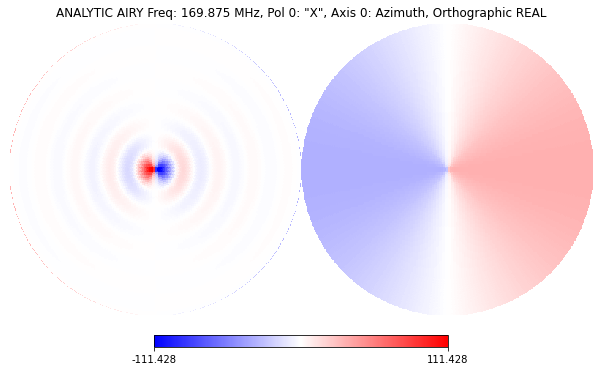

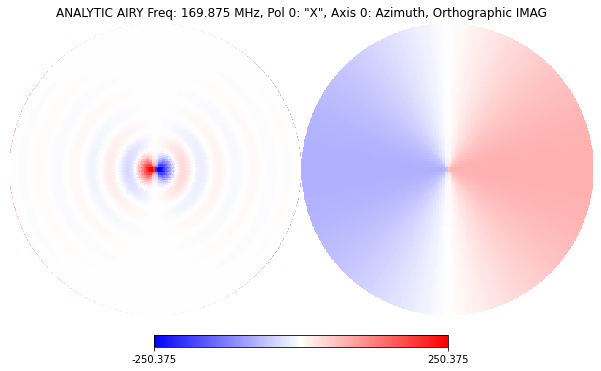

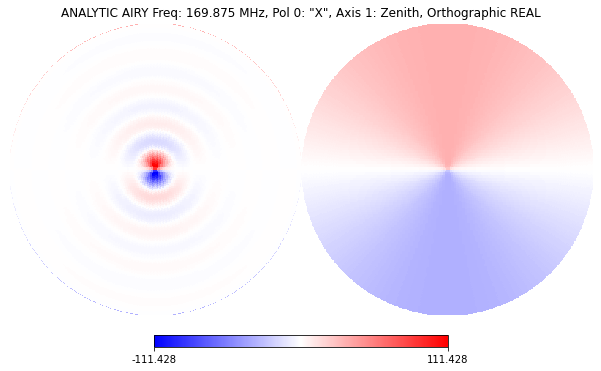

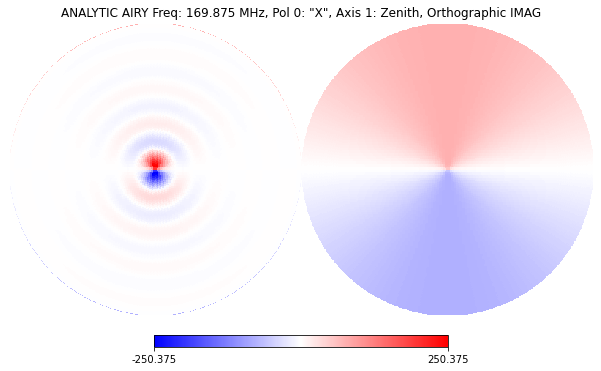

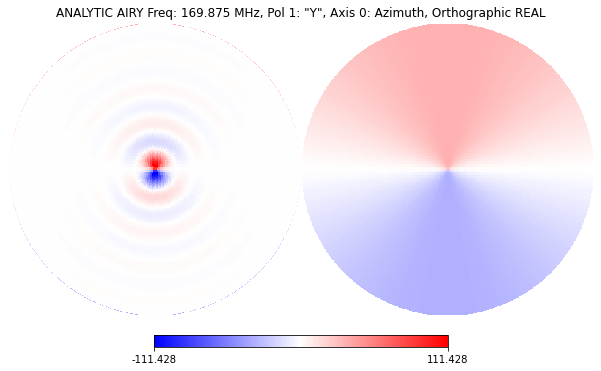

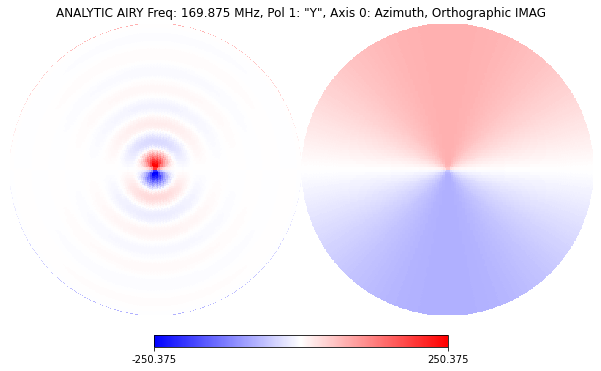

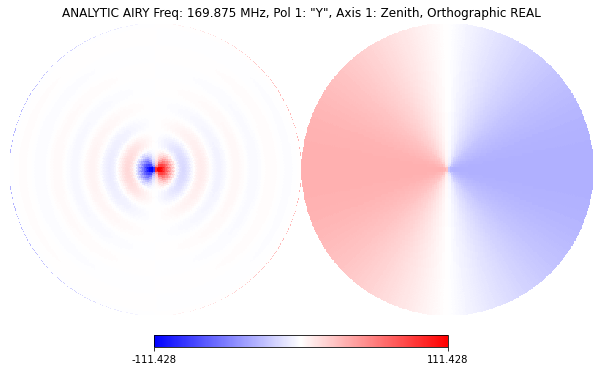

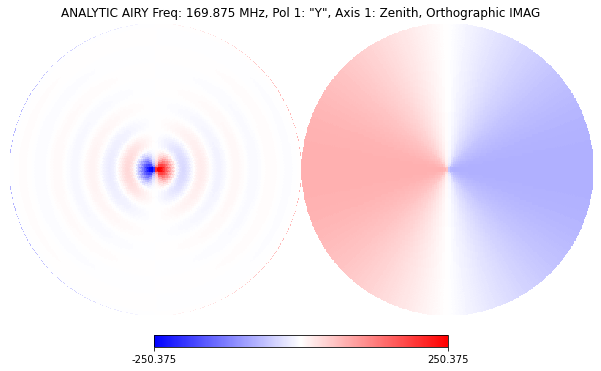

In [10]:
arr_freq_indices=[-1]
arr_str_axes=['Azimuth', 'Zenith']
arr_str_pols=['X', 'Y']
str_cmap ='bwr'

for ifreq in arr_freq_indices:
    for ip, pol in enumerate(arr_str_pols):
        for ia, ax in enumerate(arr_str_axes):
            freq_MHz = uvbE_analytic.freq_array[0][int(ifreq)]/1e6
            str_title=str('ANALYTIC AIRY Freq: '+str(freq_MHz)+' MHz, Pol '+str(ip)+': "'+str(pol)+'", Axis '+str(ia)+': '+str(ax))
            healpy.orthview(uvbE_analytic.data_array[ia, 0, ip, ifreq,:].real, rot=[0, 90], title=str(str_title+', Orthographic REAL'), cmap='bwr')
            healpy.orthview(uvbE_analytic.data_array[ia, 0, ip, ifreq,:].imag, rot=[0, 90], title=str(str_title+', Orthographic IMAG'), cmap='bwr')

In [11]:
if WRITE_E_BEAM:
    fname=str(BEAM_PATH+'/airy_analytic_efield_beam_'+str(uvbE_analytic.Nfreqs)+'_Nfreqs_'+str(uvbE_analytic.nside)+'_nside_healpix_v2.fits')
    uvbE_analytic.write_beamfits(fname, clobber=True)

Make power beam from the electric field beam

In [12]:
if WRITE_P_BEAM:
    uvbP_analytic = uvbE_analytic.efield_to_power(calc_cross_pols=True, keep_basis_vector=False, run_check=True, check_extra=True, run_check_acceptability=True, inplace=False)
    fname=str(BEAM_PATH+'/airy_analytic_power_beam_'+str(uvbE_analytic.Nfreqs)+'_Nfreqs_'+str(uvbE_analytic.nside)+'_nside_healpix_v2.fits')
    uvbP_analytic.write_beamfits(fname, clobber=True)